# **Análisis de datos de Uber**

---



Este notebook fue extraido y modificado del siguiente artículo "*End-to-End Predictive Analysis on Uber’s Data" por Sharvari Santosh, 2022*.

Artículo disponible en el [siguiente enlace](
https://www.analyticsvidhya.com/blog/2021/10/end-to-end-predictive-analysis-on-ubers-data/).

## Importación de librerias y lectura de datos de Uber

In [1]:
import math
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from folium import plugins


rides_df = pd.read_csv('./trips_data.csv')
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  554 non-null    int64  
 1   Product Type          551 non-null    object 
 2   Trip or Order Status  554 non-null    object 
 3   Request Time          554 non-null    object 
 4   Begin Trip Time       554 non-null    object 
 5   Begin Trip Lat        525 non-null    float64
 6   Begin Trip Lng        525 non-null    float64
 7   Dropoff Time          554 non-null    object 
 8   Dropoff Lat           525 non-null    float64
 9   Dropoff Lng           525 non-null    float64
 10  Distance (miles)      554 non-null    float64
 11  Fare Amount           554 non-null    float64
 12  Fare Currency         551 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 56.4+ KB


## Limpieza de datos


### Convertir strings con formato de fechas a objectos de fecha

In [2]:
from datetime import datetime
from datetime import timedelta


def date_convertion(df, cols):
  """
  Funcion para convertir a fechas los registros de las columnas que se pasan en
  el dataframe
  """
  for col in cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S %z UTC')
  return df


rides_df = date_convertion(rides_df, ['Request Time', 'Begin Trip Time', 'Dropoff Time'])


Ahora vamos crear nuevas columnas relacionadas al "Request time" para dividir en diferentes columnas.


In [3]:
rides_df['Year'] = rides_df['Request Time'].map(lambda request_time: datetime.strftime(request_time,"%Y"))
rides_df['Month'] = rides_df['Request Time'].map(lambda request_time: datetime.strftime(request_time,"%b"))
rides_df['Weekday'] = rides_df['Request Time'].map(lambda request_time: datetime.strftime(request_time,"%a"))
rides_df['Time'] = rides_df['Request Time'].map(lambda request_time: datetime.strftime(request_time,"%H:%M"))

### Remover registros de años incompletos 2015 y 2021


In [4]:
rides_df = rides_df[(rides_df['Year'] != '2015') & (rides_df['Year'] != '2021')]

### Resumir la categorias de la columna "Product Type".

En la columna _**"Product Type"**_ se pueden encontrar diferentes valores que se refieren a la misma categoria.

In [5]:
rides_df['Product Type'].value_counts()

UberX                   169
uberX                   143
uberX VIP                81
VIP                      69
POOL                     36
Pool                     12
UberEATS Marketplace     10
POOL: MATCHED             8
uberPOOL: MATCHED         5
uberPOOL                  5
Pool: MATCHED             4
Black                     2
Juntos                    1
UberBLACK                 1
uberx                     1
Name: Product Type, dtype: int64

Resumiremos las 15 categorias anteriores a 5 tipos:

1. UberX
2. Pool
3. UberEATS Marketplace
4. Black
5. Juntos

In [6]:
# Categories reclassification
product_mapping = {
  'UberX':'UberX',
  'uberX':'UberX',
  'uberx':'UberX',
  'uberX VIP':'UberX',
  'VIP':'UberX',

  'POOL':'Pool',
  'POOL: MATCHED':'Pool',
  'uberPOOL':'Pool',
  'uberPOOL: MATCHED':'Pool',
  'Pool: MATCHED':'Pool',

  'UberBLACK': 'Black',
}
# New categories replacement
rides_df['Product Type'].replace(product_mapping, inplace=True)

# Checking new categories in Product Type column
print(rides_df['Product Type'].value_counts())

UberX                   463
Pool                     70
UberEATS Marketplace     10
Black                     3
Juntos                    1
Name: Product Type, dtype: int64


### Descartar los registros que se categorizaron como registros de "UberEATS Marketplace".

Vamos a remover los registros de UberEATS dado que este notebook se refiere a viajes de Uber.

In [7]:
rides_df = rides_df[rides_df['Product Type'] != 'UberEATS Marketplace']

# Ver las categorias de la columna "Product Type"
rides_df['Product Type'].value_counts()

UberX     463
Pool       70
Black       3
Juntos      1
Name: Product Type, dtype: int64

### Descartar datos de viajes cancelados

Dado que las características de los registros de viajes cancelados no serán útiles en este análisis, les configuramos valores nulos en las columnas para despejar un poco el dataframe.

In [8]:
rides_df.loc[
  (rides_df['Trip or Order Status'] == 'CANCELED') |
  (rides_df['Trip or Order Status'] == 'DRIVER_CANCELED'),
  ['Request Lead Time', 'Amount Km', 'Begin Trip Time', 'Dropoff Time']] = np.nan

## Nuevas columnas "Distance Km", "Amount Km", "Request Lead Time" y "Trip Duration".

### Nuevas columnas "Distance Km" y "Amount Km"

Generamos dos columnas de que nos ayudara a entender cuánto cuesta el viaje por kilometro.

In [9]:
km_in_a_mile = 1.60934
rides_df['Distance Km'] = round(rides_df['Distance (miles)'] * km_in_a_mile, 2)
rides_df['Amount Km'] = round(rides_df['Fare Amount'] / rides_df['Distance Km'], 2)

### Nueva columna "Request Lead Time"

Podemos determinar el tiempo de espera (en minutos) desde que se solicitó un viaje hasta que se inició.

In [10]:
rides_df['Request Lead Time'] = rides_df['Begin Trip Time'] - rides_df['Request Time']

rides_df['Request Lead Time'] = rides_df['Request Lead Time']\
  .apply(lambda x: round(x.total_seconds() / 60, 1))


### Nueva columna "Trip Duration"

Similar a lo anterior, podemos sabes cuánto tiempo (en minutos) que se emplea en cada viaje.

In [11]:
rides_df['Trip Duration'] = rides_df['Dropoff Time'] - rides_df['Begin Trip Time']
rides_df['Trip Duration'] = rides_df['Trip Duration']\
  .apply(lambda x: round(x.total_seconds()/60, 1))

## Data Analysis:

Para organizar mejor el análisis, crearemos un dataframe adicional, eliminando todos los viajes cancelados ya que no deben tenerse en cuenta en algunas consultas.

In [12]:
completed_rides_df = rides_df[(rides_df['Trip or Order Status'] != 'CANCELED') & (rides_df['Trip or Order Status'] != 'DRIVER_CANCELED')]

### *a. ¿Cuántas veces he viajado en el pasado?*

Podemos ver que hay un descenso significativo de 2019 a 2020 (-51%).

**Esto se explica fácilmente por el brote de COVID.**

Total trips:  540
2016     20
2017    140
2018    189
2019    119
2020     72
Name: Year, dtype: int64


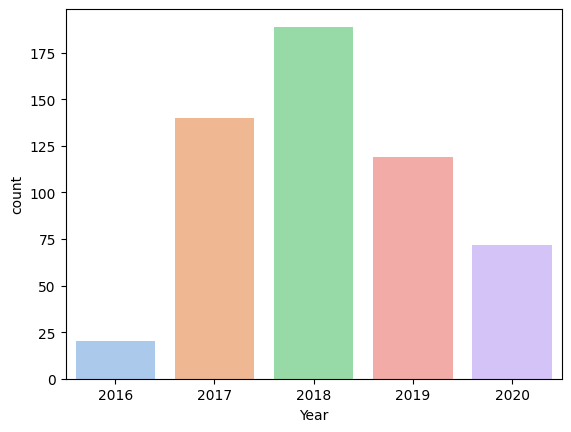

In [13]:
print('Total trips: ', rides_df['Trip or Order Status'].count())
print(rides_df['Year'].value_counts().sort_index(ascending=True))


sns.countplot(data=rides_df, x='Year',order=['2016','2017','2018','2019','2020'], palette='pastel');

### *b. ¿Cuántos viajes se completaron o cancelaron?*

2020 es el año con mayor registro de cancelaciones.



Trip status percentage per year
 Year  Trip or Order Status
2016  COMPLETED               0.850000
      CANCELED                0.150000
2017  COMPLETED               0.857143
      CANCELED                0.135714
      DRIVER_CANCELED         0.007143
2018  COMPLETED               0.772487
      CANCELED                0.179894
      DRIVER_CANCELED         0.031746
      UNFULFILLED             0.015873
2019  COMPLETED               0.890756
      CANCELED                0.092437
      DRIVER_CANCELED         0.016807
2020  COMPLETED               0.722222
      CANCELED                0.263889
      DRIVER_CANCELED         0.013889
Name: Trip or Order Status, dtype: float64


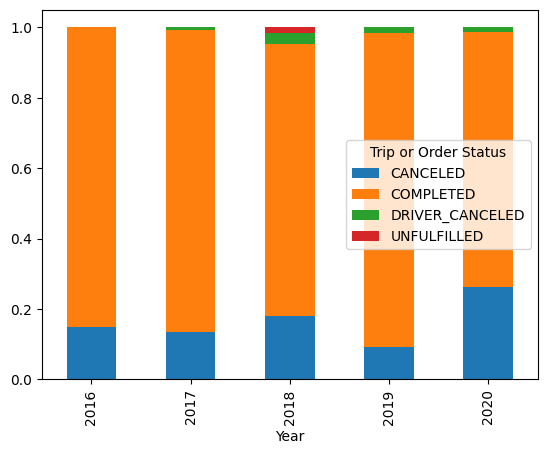

In [14]:
trip_status_percentage_per_year_df = rides_df.groupby(by=['Year'])['Trip or Order Status'].value_counts(normalize=True)
print('\n\nTrip status percentage per year\n', trip_status_percentage_per_year_df)
trip_status_percentage_per_year_df.unstack('Trip or Order Status').plot.bar(stacked=True);


### c. ¿Dónde se produjeron la mayoría de destinos?


In [15]:
coord=[]
for lat,lng in zip(completed_rides_df['Dropoff Lat'].values, completed_rides_df['Dropoff Lng'].values):
  if math.isnan(lat) or math.isnan(lng):
    continue
  coord.append([lat,lng])


map = folium.Map(
    location=[-23.5489,-46.6388],
    tiles='Stamen Terrain',
    zoom_start=7,
    width='80%',
    height='50%',
    control_scale=True)
map.add_child(plugins.HeatMap(coord))
map

### d. Qué tipo de producto se elige con más frecuencia?


Product Type  Black  Pool  UberX
Year                            
2016              0     3     14
2017              0    15    105
2018              1    21    124
2019              1     0    105
2020              1     0     51


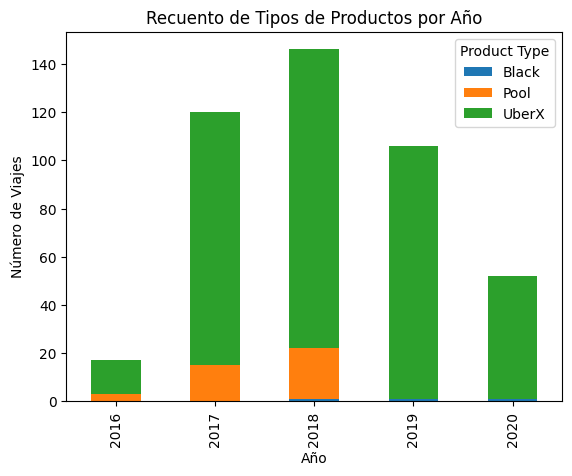

In [16]:
# Agrupar por el año y contar el número de viajes para cada tipo de producto
product_type_counts_by_year = completed_rides_df.groupby(['Year', 'Product Type']).size().unstack(fill_value=0)

# Crear un DataFrame con los recuentos de cada tipo de producto por año
product_type_counts_df = pd.DataFrame(product_type_counts_by_year)

# Mostrar los recuentos y porcentajes por año
print(product_type_counts_df)

# Gráfico de barras para el recuento de tipos de productos por año
product_type_counts_df.plot(kind='bar', stacked=True)
plt.xlabel('Año')
plt.ylabel('Número de Viajes')
plt.title('Recuento de Tipos de Productos por Año')
plt.show()

      % Black  % Pool  % UberX
Year                          
2016      0.0    17.6     82.4
2017      0.0    12.5     87.5
2018      0.7    14.4     84.9
2019      0.9     0.0     99.1
2020      1.9     0.0     98.1


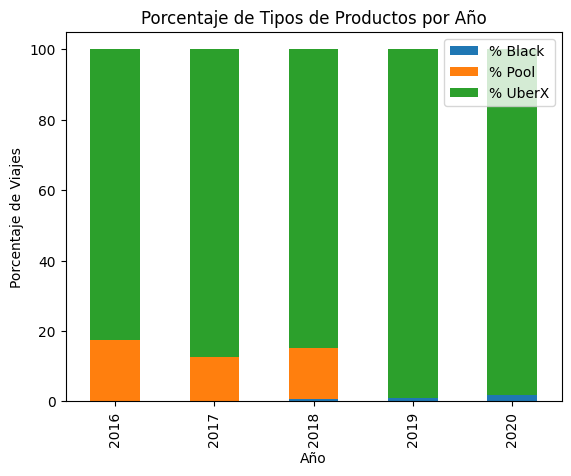

In [17]:
# Calcular el porcentaje de cada tipo de producto por año
product_type_percentages_by_year = product_type_counts_df.divide(product_type_counts_df.sum(axis=1), axis=0) * 100
product_type_percentages_by_year = product_type_percentages_by_year.round(1)

# Renombrar las columnas
product_type_percentages_by_year.columns = [f'% {col}' for col in product_type_percentages_by_year.columns]

print(product_type_percentages_by_year)

# Gráfico de barras para los porcentajes de tipos de productos por año
product_type_percentages_by_year.plot(kind='bar', stacked=True)
plt.xlabel('Año')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Tipos de Productos por Año')
plt.show()


### e. ¿Cuál es la tarifa, la distancia, el importe y el tiempo empleado en el trayecto?




In [18]:
# @title
# Agrupar por el año y calcular sumas y promedios
grouped_data = completed_rides_df.groupby('Year').agg({
    'Fare Amount': ['sum', 'mean'],
    'Distance Km': ['sum', 'mean'],
    'Trip Duration': ['sum', 'mean']
}).round(1)

# Calcular la tarifa por kilómetro promedio
grouped_data[('Fare Amount', 'avg_fare_per_km')] = grouped_data[('Fare Amount', 'sum')] / grouped_data[('Distance Km', 'sum')]


# Mostrar los resultados
print(grouped_data)


     Fare Amount       Distance Km      Trip Duration           Fare Amount
             sum  mean         sum mean           sum  mean avg_fare_per_km
Year                                                                       
2016       346.9  20.4       130.3  7.7         340.0  20.0        2.662318
2017      2248.1  18.7       929.8  7.7        2431.5  20.3        2.417832
2018      2923.7  19.6      1316.5  8.8        3167.0  21.3        2.220813
2019      1753.0  16.5       713.1  6.7        2126.6  20.1        2.458281
2020      1176.4  22.6       459.4  8.8        1377.4  26.5        2.560731
